In [ ]:
"""
Requirements
pip install scipy==1.9.3 scanpy igraph harmonypy
"""
import scanpy as sc
import harmonypy as hm

In [ ]:
# Convert h5 to h5AD
# NOTE: VERY SLOW, 10 minutes+
adata = sc.read_10x_h5('GSE178341_crc10x_full_c295v4_submit.h5')
adata.write_h5ad('GSE178341_crc10x_full_c295v4_submit.h5ad')

In [ ]:
adata = sc.read_h5ad("GSE178341_crc10x_full_c295v4_submit.h5ad")

In [ ]:
# Identify mitochondrial genes (assuming human dataset with 'MT-' prefix)
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Compute QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

# View QC metrics
print(adata.obs[["total_counts", "n_genes_by_counts", "pct_counts_mt"]].head())

In [ ]:
# Define QC thresholds
min_genes = 200  # Cells must have at least 200 genes
max_genes = 5000  # Remove cells with very high gene counts
max_mt = 5  # Remove cells with >5% mitochondrial RNA

# Apply filtering
adata = adata[adata.obs.n_genes_by_counts > min_genes, :]
adata = adata[adata.obs.n_genes_by_counts < max_genes, :]
adata = adata[adata.obs.pct_counts_mt < max_mt, :]

print(f"Remaining cells after filtering: {adata.n_obs}")

In [ ]:
# Filter Out Low-Quality Genes
sc.pp.filter_genes(adata, min_cells=3)  # Keep genes present in at least 3 cells

In [ ]:
# Normalize & Log-Transform Data for downstream analysis
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
# Identify Highly Variable Genes
# Select genes that show high variability across cells
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Keep only highly variable genes
adata = adata[:, adata.var.highly_variable]

print(f"Number of highly variable genes: {adata.shape[1]}")

In [ ]:
# Save the Processed Data
adata.write("GSE178341_QC.h5ad")

In [2]:
adata = sc.read_h5ad("GSE178341_QC.h5ad")

In [ ]:
"""
FORMAT obs_names = C[PatientID]_[Region]_[X]_[Y]_[Z]_c[Cluster]_v[Version]_[Barcode]
T, N, TA, TB → Sample Type / Region
    T → Tumor sample
    N → Normal (adjacent) tissue
    TA, TB → Multiple tumor regions (possibly from different sections of the same tumor or replicates from the same patient)
"""
obs_names = adata.obs_names.str.split('_')
adata.obs["batch"] = obs_names.str[0] # Patient IDs
adata.obs["region"] = obs_names.str[1] # Sample Regions
print(adata.obs["batch"].value_counts())  # Number of cells per patient sample

batch
C129    6895
C126    6013
C132    5579
C124    5026
C130    4283
        ... 
C168      90
C160      86
C172      83
C173      75
C161      33
Name: count, Length: 62, dtype: int64


In [5]:
# Perform PCA and clustering
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/Users/rosiepham/Desktop/BENG204/Group Project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Run Harmony for batch correction
adata.obsm["X_pca_harmony"] = hm.run_harmony(adata.obsm["X_pca"], adata.obs, 'batch').Z_corr.T # transpose result to fit expected shape

2025-03-02 21:46:20,039 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-02 21:46:55,819 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-02 21:46:57,233 - harmonypy - INFO - Iteration 1 of 10
2025-03-02 21:48:12,168 - harmonypy - INFO - Iteration 2 of 10
2025-03-02 21:49:25,820 - harmonypy - INFO - Iteration 3 of 10
2025-03-02 21:50:19,360 - harmonypy - INFO - Converged after 3 iterations


(50, 95293)


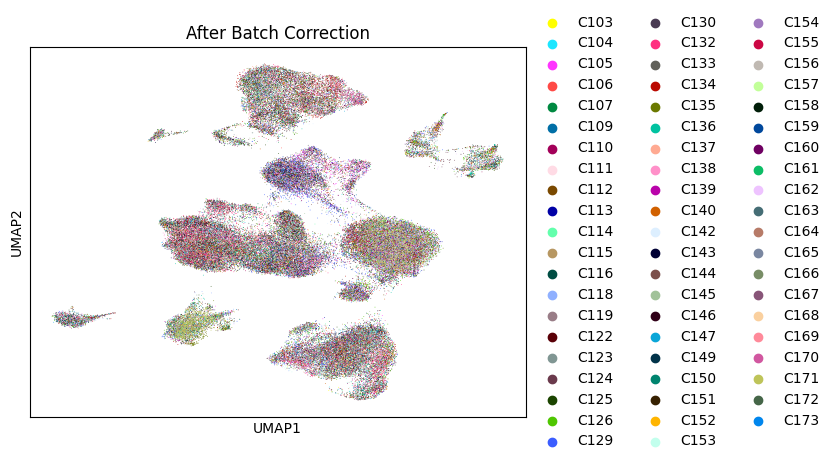

In [ ]:
# Update neighbors & recompute UMAP
sc.pp.neighbors(adata, use_rep="X_pca_harmony")
sc.tl.umap(adata)
sc.pl.umap(adata, color="batch", title="Batch Corrected")

In [ ]:
# Leiden clustering 
sc.tl.leiden(adata, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)

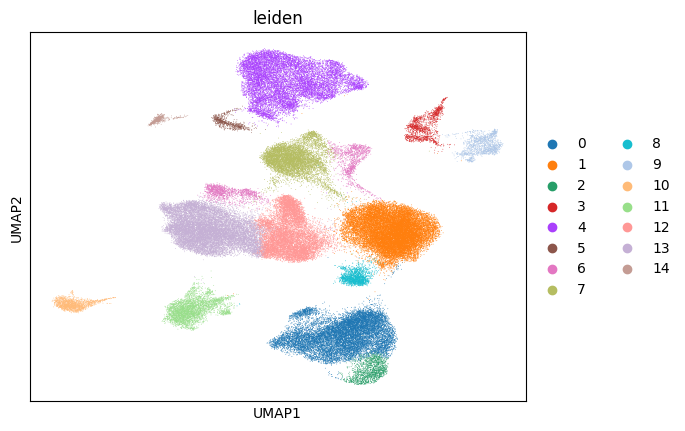

In [ ]:
sc.pl.umap(adata, color=['leiden'])

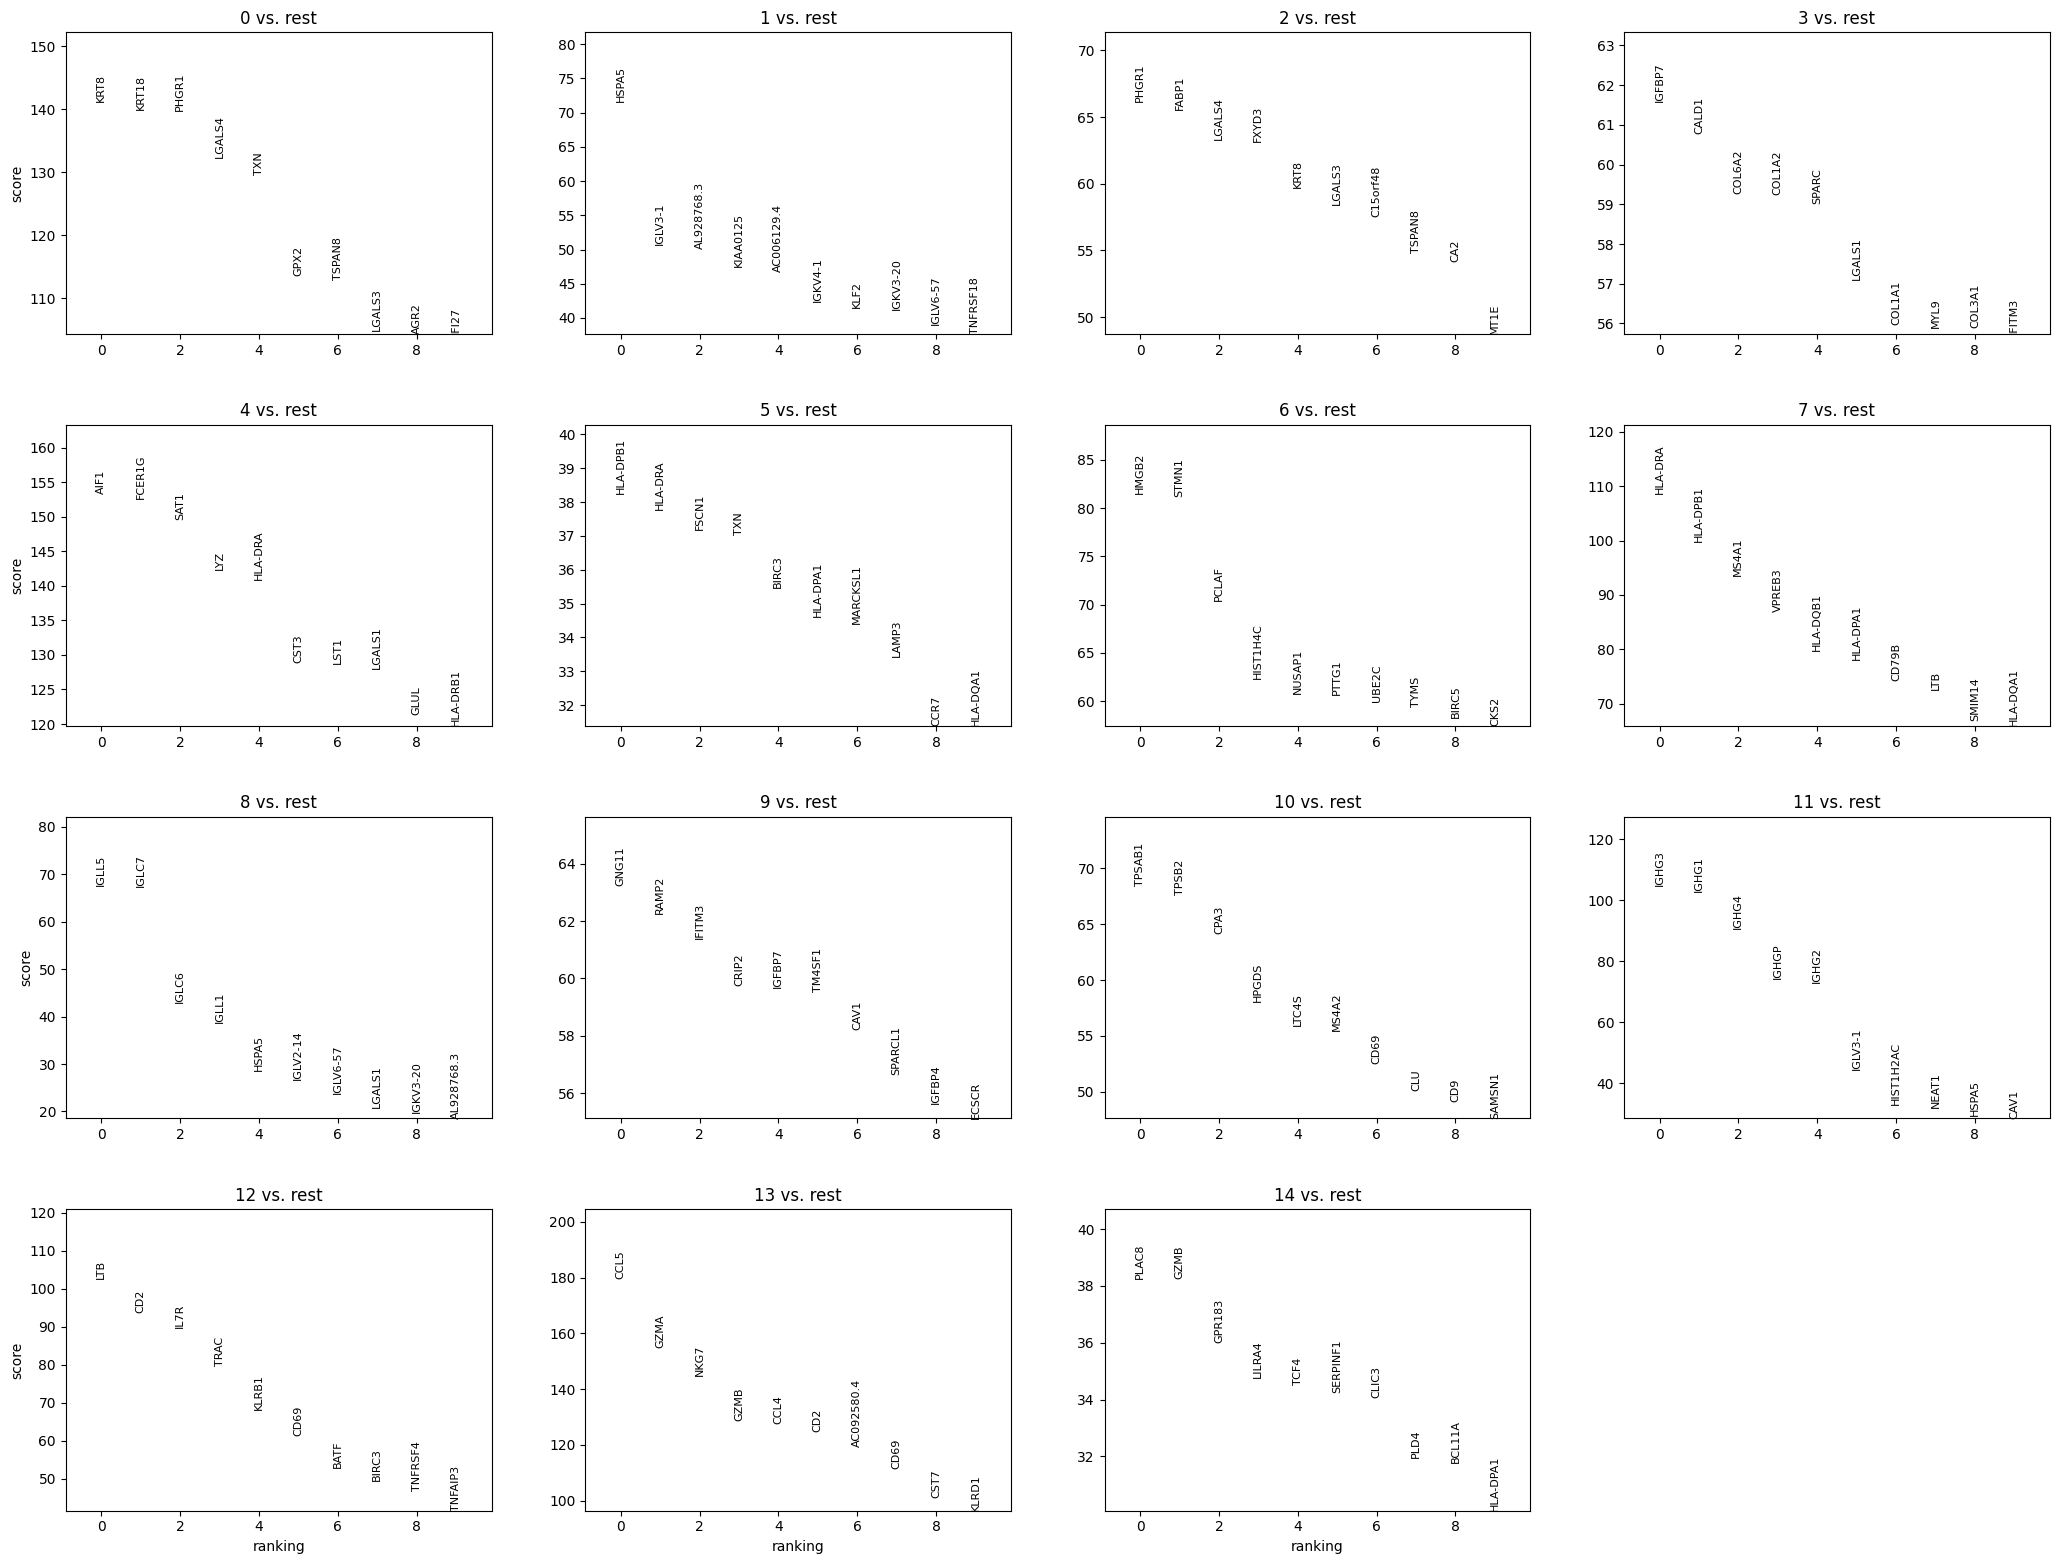

In [ ]:
# Find the top-expressed genes in each cluster
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

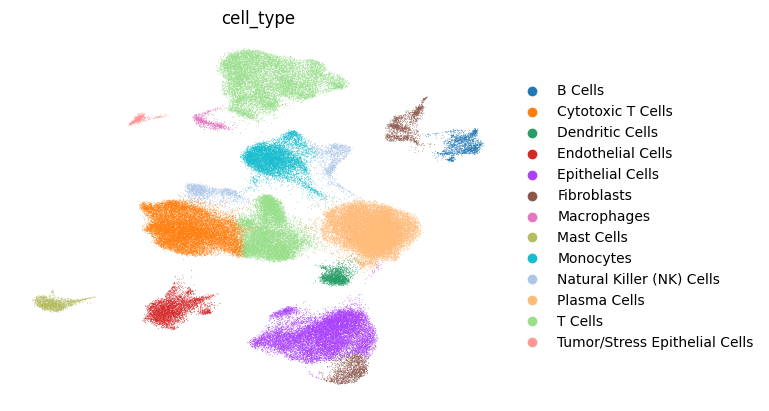

In [ ]:
# Define cluster labels based on marker genes (from above)
cluster_labels = {
    "0": "Epithelial Cells",
    "1": "Plasma Cells",
    "2": "Fibroblasts",
    "3": "Fibroblasts",
    "4": "T Cells",
    "5": "Macrophages",
    "6": "Natural Killer (NK) Cells",
    "7": "Monocytes",
    "8": "Dendritic Cells",
    "9": "B Cells",
    "10": "Mast Cells",
    "11": "Endothelial Cells",
    "12": "T Cells",
    "13": "Cytotoxic T Cells",
    "14": "Tumor/Stress Epithelial Cells"
}

# Map cell type labels to leiden clusters
adata.obs["cell_type"] = adata.obs["leiden"].map(cluster_labels)

# Visualize UMAP with new labels
sc.pl.umap(adata, color="cell_type", frameon=False)

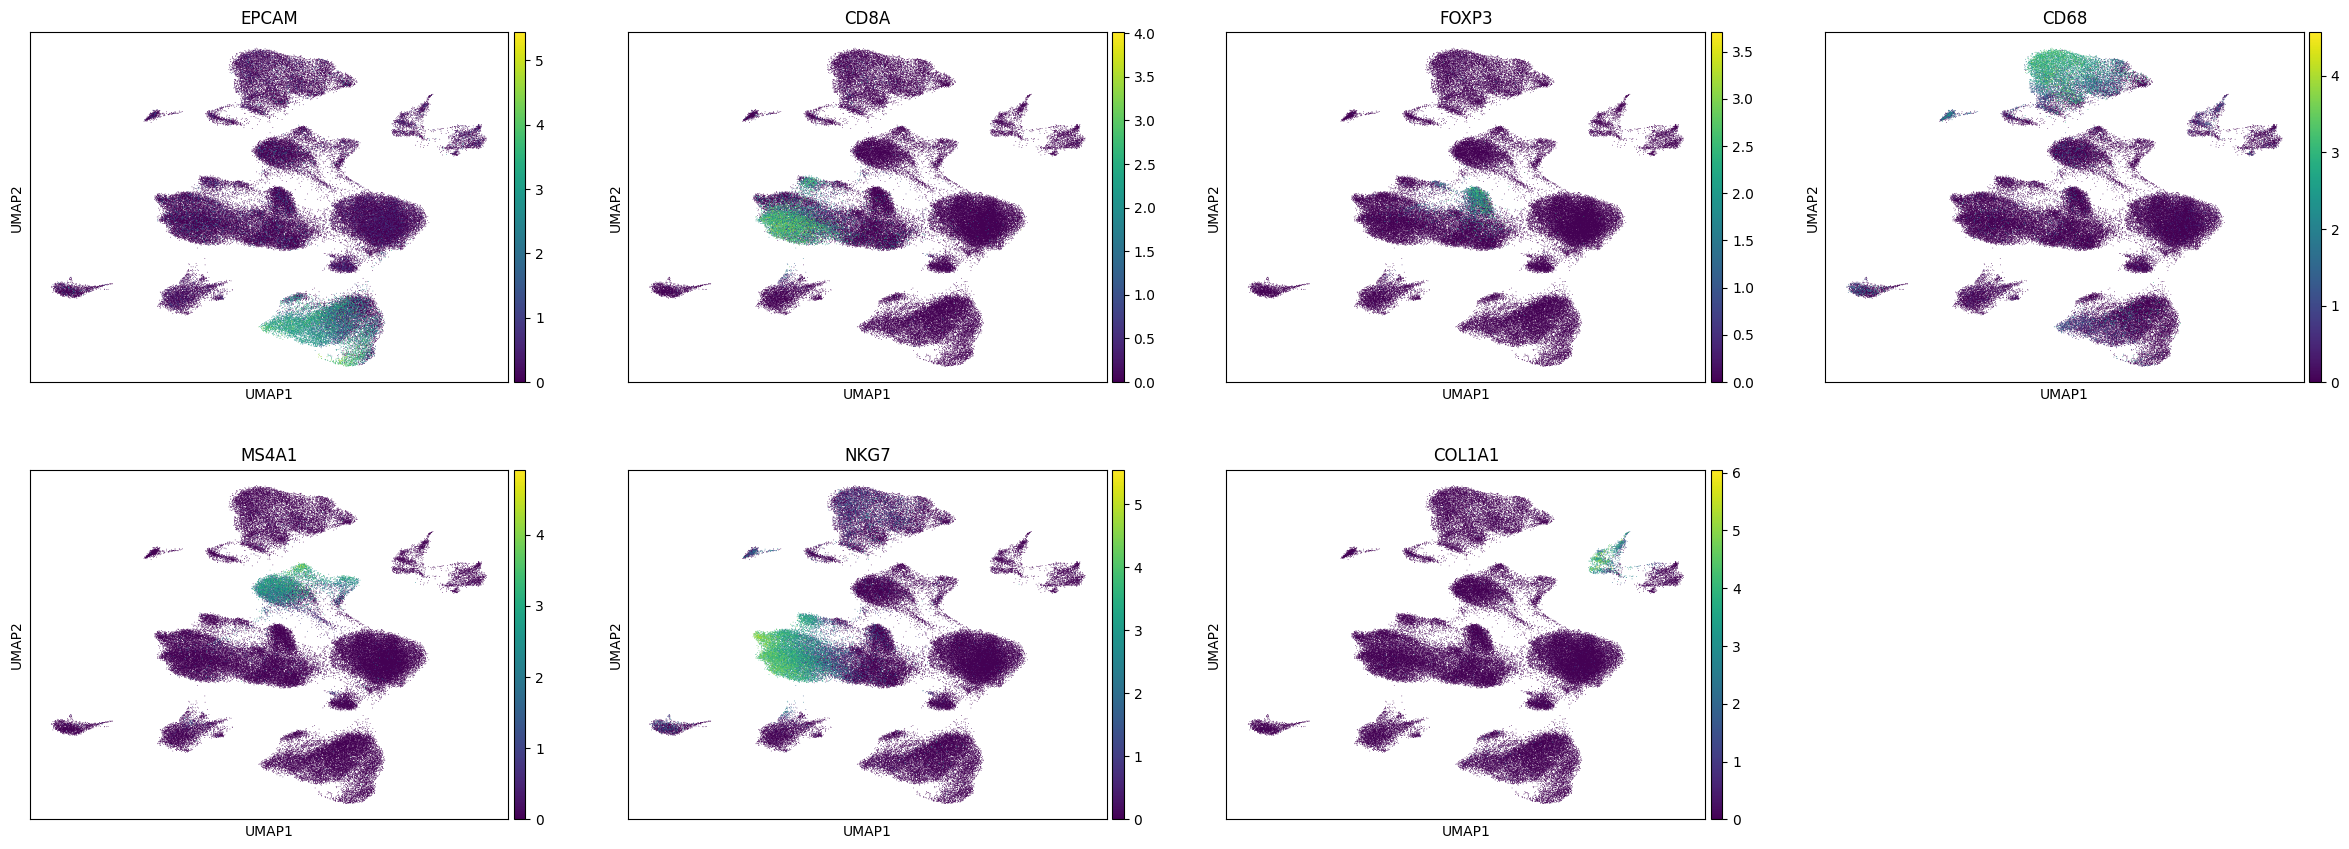

In [ ]:
# Verify marker genes correlate with existing clusters
sc.pl.umap(adata, color=["EPCAM", "CD8A", "FOXP3", "CD68", "MS4A1", "NKG7", "COL1A1"], cmap="viridis")

In [ ]:
# Rank genes by cell type (leiden cluster)
sc.tl.rank_genes_groups(adata, groupby="cell_type", method="wilcoxon")

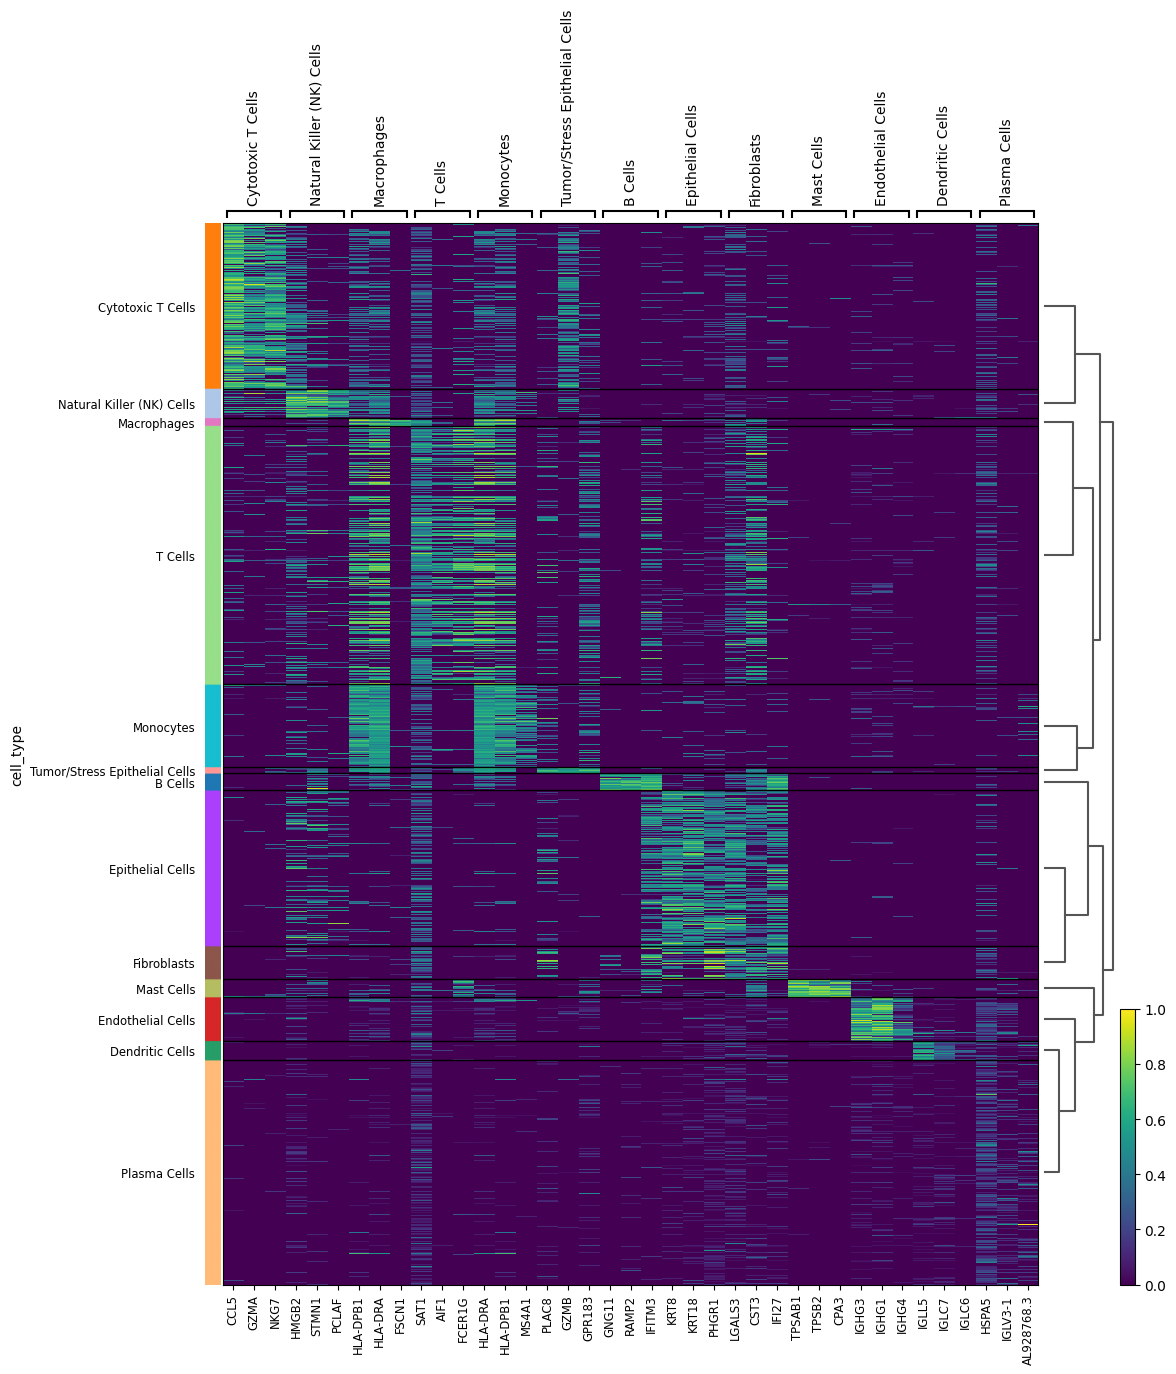

In [ ]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=3,
    groupby="cell_type",
    cmap="viridis",
    standard_scale="var",
    figsize=(12, 14),
)